### Authors
1. Ng Woon Yee

2. Lee Si-Ying Celest

3. Lee Jun Yong

4. Phoen Yu Heng Ryan

In [20]:
from IPython.core.display import Image, display

C:\Users\snorl\AppData\Local\Temp\ipykernel_17616\3464626361.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import random

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 3. Unsupervised Learning with Kernel Methods

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Optical recognition of handwritten digits dataset

The [optical recognition of handwritten digits dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) is another classic benchmark from the UCI repository. The dataset contains $8\times 8$ matrices obtained processing bitmaps of handwritten digits from preprinted forms. 

The original bitmaps are $32\times 32$ pixels. The observations are the result of divinding these bitmaps into nonoverlapping $4\times 4$ and counting the number of black pixels in each block. Therefore observations are rows of integers that take values between 0 and 16. A value of $0$ means the block $4\times 4$ block in that position was a blank block while a value of 16 indicates all the pixels of that block were inked. 

There are 10 classes, with class names 0 to 9, each class name refers to the corresponding digit.

Each observation can be regarded as a low resolution image of each original handwritten digit. 

In [4]:
from sklearn.datasets import load_digits

data = load_digits()
X = data['data']
Y = data['target']
print("{0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("{0:d} targets".format(len(Y)))
print("Values of the targets:")
print(np.unique(Y))

1797 observations with 64 columns
1797 targets
Values of the targets:
[0 1 2 3 4 5 6 7 8 9]


## Plot some examples

The function `plot_ten_examples` receives ten rows with observations in argument `X` and their corresponding targets in argument `y` and plots the digits.


In [5]:
def plot_ten_examples(X,y, score=None):
  nrows = 2
  ncols = 5
  ff,aa = plt.subplots(nrows, ncols,figsize=(12,2))
  ii = 0
  for rr in range(nrows):
    for cc in range(ncols):
      aa[rr][cc].set_axis_off()
      aa[rr][cc].imshow(X[ii].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
      if score is None:
        aa[rr][cc].set_title('Target: {0:d}'.format(y[ii]))
      else:
        aa[rr][cc].set_title('Target: {0:d}, score:{1:.3f}'.format(y[ii], score[ii]))
      ii += 1
  ff.tight_layout()    

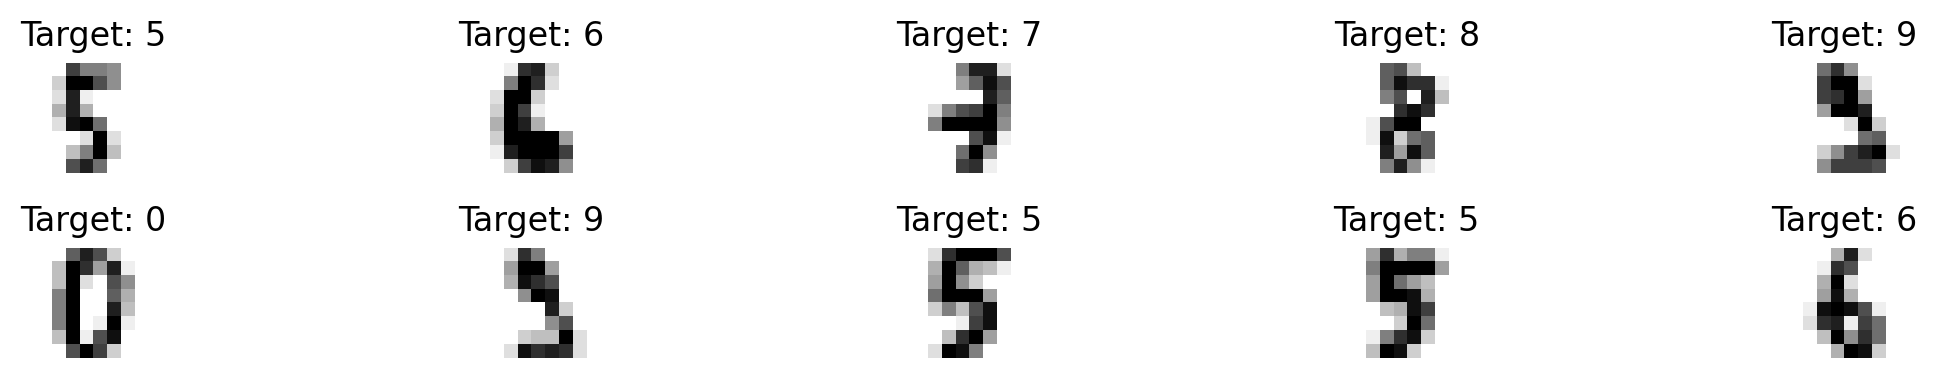

In [6]:
# plot digits in rows 25 to 34 in X
plot_ten_examples(X[25:35,:],Y[25:35])

## Separation in training and test set

First partition the dataset moving a 50% of the observations to the training set and  and the remaining 50% to the test set. 

For simplicity, use the names `X_train, X_test, y_train, y_test` for the corresponding numpy arrays.


In [7]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# 1. Definition of the novelty detection tasks

In this assignment you are going to work with different degrees of supervision in three novelty detection tasks. These novelty detection tasks will be simulated using classification tasks in which we will alter the training set by removing partially or totally the instances of some digits. The test set will be always the same, therefore the novelty stands in the fact that in the test set there will be members of digits that were not present (or very poorly represented) in the training set. 


The novelty detections tasks are the following:

1. The training set is formed exclusively by instances of 5. As the test set has instances of all digits, the novelty is the presence of instances of digits different from 5.
2. The training set has no instances of digits 5,6,7,8 and 9. The novelty is the presence of examples of digits 5,6,7,8 and 9 in the test set.

We have prepared two python functions that receive generic training and test set (observations are images of all the digits and targets are integers between 0 and 9) and output the training set observations and labels and the test set labels. Notice the test set observations are always the same.

The functions are `just_fives` and `zero_four`. For example, for the first novelty detection task, where the training set only has instances of digit 5, one should create the corresponing sets using:

`x_train_5, y_train_5, y_test_5, = just_fives(X_train, y_train, y_test, number_novel_instances=0)`

- `x_train_5`: rows of `X_train` that correspond with instances of digit 5. If `number_novel_instances`> 0, there will be some rows in `x_train_5` with instances of other digits.

- `y_train_5`: true binary labels of the rows of `x_train_5` for computing classification scores. If row $i$ of `x_train_5` is an instance of digit 5, then `y_train_5[i]` is 1. Otherwise `y_train_5[i]` is -1.

- `y_test_5`: true binary labels of the rows of `X_test` for computing classification scores. If row $i$ of `X_test` is an instance of digit 5, then `y_test_5[i]` is 1. Otherwise `y_test_5[i]` is -1.

- `number_novel_instances`: number of instances of other digits than 5 in `x_train_5` and `y_train_5`. A value of `number_novel_instances` = $k$ means that the last $k$ rows of `x_train_5` will contain instances of digits different from 5, and therefore the last $k$ elements of `y_train_5` will be -1. Notice $k$ must be smaller than the number of non-five digits in `X_train`.






In [8]:
def just_fives(x_train, y_train, y_test, number_novel_instances=0):
  
  is_5 = np.where(y_train==5)[0]
  n5 = len(is_5)
  xr = x_train[is_5,:].copy()
  yr = np.ones(n5, dtype='int')
  yt = -np.ones(len(y_test), dtype='int')
  yt[y_test==5] = 1
  
  
  if number_novel_instances > 0:
    n_not_5 = len(y_train) - n5
    if number_novel_instances < n_not_5:
      my_idx_negs = random.sample(range(n_not_5), k=number_novel_instances)
    else:
      my_idx_negs = range(n_not_5)
    is_not_5 = np.where(y_train != 5)[0][my_idx_negs]
    
    xr = np.vstack((xr, x_train[is_not_5,:].copy()))
    yr = np.hstack((yr, -np.ones(len(is_not_5), dtype='int')))
    
  return xr, yr, yt


def zero_four(x_train, y_train, y_test, number_novel_instances=0):
  is_5 = np.where(y_train < 5)[0]
  n5 = len(is_5)
  xr = x_train[is_5,:].copy()
  yr = np.ones(n5, dtype='int')
  yt = np.ones(len(y_test), dtype='int')
  yt[y_test>=5] = -1
  
  
  if number_novel_instances > 0:
    n_not_5 = len(y_train) - n5
    if number_novel_instances < n_not_5:
      my_idx_negs = random.sample(range(n_not_5), k=number_novel_instances)
    else:
      my_idx_negs = range(n_not_5)
    
    is_not_5 = np.where(y_train >= 5)[0][my_idx_negs]
    xr = np.vstack((xr, x_train[is_not_5,:].copy()))
    yr = np.hstack((yr, -np.ones(len(is_not_5), dtype='int')))

  return xr, yr, yt

## 1.1 Evaluation of the performance

In this assignment you will use the **confusion matrix** to evaluate the performance of the methods. The confusion matrix captures all the possible outcomes of a classifier. In a multiclass classification problem with $M$ classes, the confusion matrix is a $M\times M$ matrix $C$ where position $M_{ij}$ counts the number of instances of class $i$ in the test set that were predicted as instances of class $j$ by the classifier. Therefore large numbers in main diagonal of $C$ indicate a successful performance while the elements in off-diagonal positions account for errors.

In a binary classification problem (and the novel detection can be cast as a binary classification setting where the positive class is formed by normal observations and the negative class is formed by the novel observations) each output of the classifier can be categorized in one of these groups:
- True positive (TP): test observations whose true class is the positive one and the classifier correctly classifies

- False negative (FN): test observations whose true class is the positive one but the classifier classifies as negative

- True negative (TN): test observations whose true class is the negative one and the classifier correctly classifies

- False positive (FP): test observations whose true class is the negative one but the classifier classifies as positive. 

With this notation the confusion matrix in a binary case is
$$
C = \left [ \begin{array}{cc} TN & FP \\ FN & TP \end{array}\right ]
$$
For normalization purposes, the rows of $C$ add up to the number of test observations in each true class while the columns of $C$ add up to the number of test observations classified to each class.

The confusion matrix is implemented in sklearn in function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

# 2. One-Class SVM for novelty detection.
The first exercise of the assignment consists in to evaluate the capabilities of the sklearn implementation of One-class SVM [One-class SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) as novelty detector.

You are using RBF kernels and to avoid tunig the value of $\gamma$ use a value `gamma= "scale"`.

There is a key parameter in the implementation of OneClassSVM called `nu`. This parameter controls the regularization (similar role to $C$) in the sense that `nu` is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval $(0, 1]$. For instance `nu=0.3` means that at least 30% of the training data will become support vectors, that is, they will en up either on the margin (being inliers) or on the wrong side of the margin. Some of the support vectors on the wrong side of the margin will eventually become outliers as they will be also on the wrong side of the classification boundary (in this case the classification boudnary separates inliers from outliers). This is why `nu` can be considered an upper bound for the number of errors.

## 2.1. Training set with only fives case.

First use function `just_fives` to obtain the data corresponding to the task in which there are only instances of 5 in the training set.


In [9]:
X_train_5, y_train_5, y_test_5 = just_fives(X_train, y_train, y_test,0)

### 2.1.1 Dependence with `nu`

Complete the code of the following function that will help you study the performance of OneClassSVM in this novelty detection task. 

Consider the following range of variation of `nu`:

$$
\mbox{nu } \in \{ 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2\}
$$

In [10]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

def simulate_oneclasssvm_nu(x_train, x_test, y_train, y_test, range_nu):
  tn = np.empty(len(range_nu)) # true negatives for every value of nu
  fp = np.empty(len(range_nu)) # false positives for every value of nu
  fn = np.empty(len(range_nu)) # false negatives for every value of nu
  tp = np.empty(len(range_nu)) # true positives for every value of nu

  """
  YOUR CODE

  Implement a loop that iterates over the values of range_nu. For each iteration
  1. instantiate a OneClassSVM with the value of nu fixed to one that corresponds 
    to the current iteration
  2. train the OneClassSVM with x_train and y_train
  3. predict the outlier or inlier condition for the rows of x_test
  4. call confusion_matrix to obtain TN, FP, FN, TP and fill the corresponding
     position of arrays tn, fp, fn and tp
  """

  for i, nu in enumerate(range_nu):
    # 1. Instantiate a OneClassSVM with the current nu value
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)

    # 2. Train the OneClassSVM with x_train and y_train
    model.fit(x_train, y_train)

    # 3. Predict the outlier or inlier condition for the rows of x_test
    predictions = model.predict(x_test)

    # 4. Call confusion_matrix to obtain TN, FP, FN, TP
    cm = confusion_matrix(y_test, predictions)
    tn[i], fp[i], fn[i], tp[i] = cm.ravel()
 
  return tn, fp, fn, tp

#### Plot the dependence of the performance with nu

Call `simulate_oneclasssvm_nu` with the outcome of `just_fives` and plot the evolution of true negatives, false positives, false negatives and true positives in the novelty detection as `nu` varies. 

Discuss:
- What is the method better at? 
  - detecting 5s in the test set
  - detecting novelties in the test set 

- How is the variation of the performance with `nu`? Any explanation?

Hint: use logarithmic scale in the x-axis, to better accommodate the selected range for `nu` 

[799. 799. 799. 799. 799. 799. 799. 800.] [1. 1. 1. 1. 1. 1. 1. 0.] [20. 19. 19. 19. 19. 19. 21. 30.] [79. 80. 80. 80. 80. 80. 78. 69.]


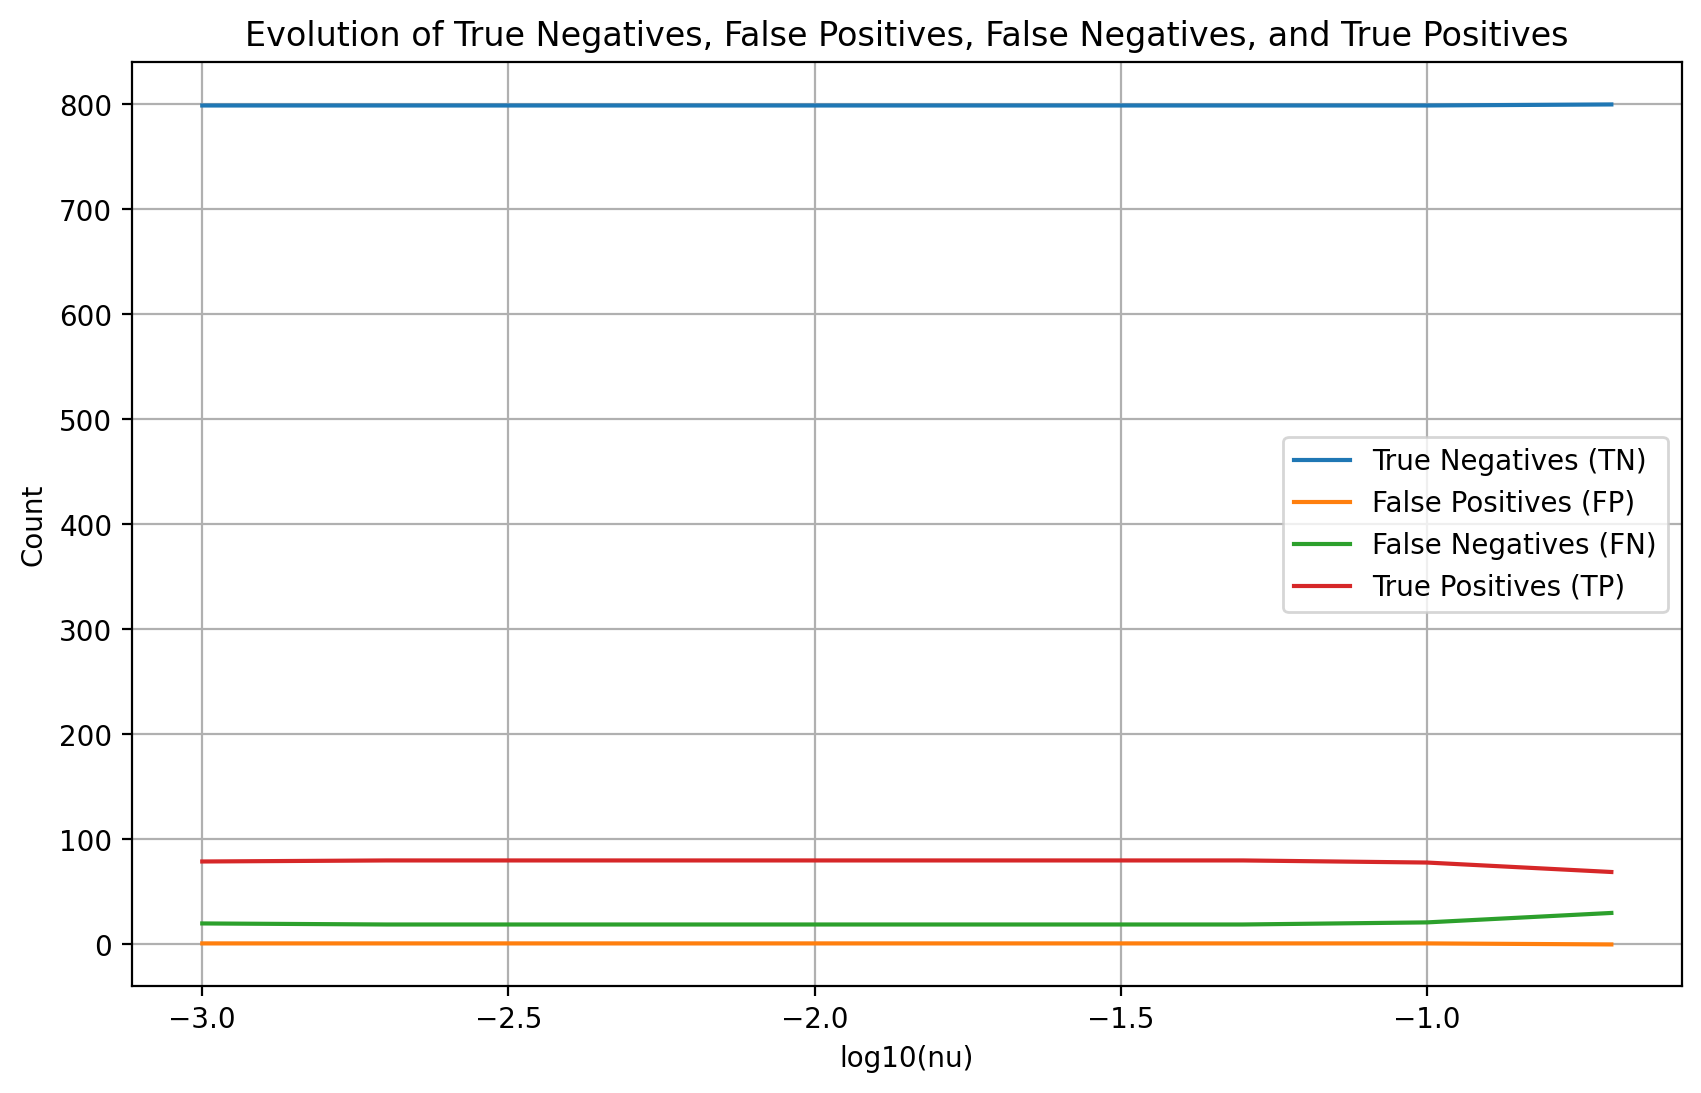

In [11]:
#############
# YOUR CODE #
#############

import numpy as np
import matplotlib.pyplot as plt

# Define the range of nu values
range_nu = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# Call simulate_oneclasssvm_nu with the outcome of just_fives
tn, fp, fn, tp = simulate_oneclasssvm_nu(X_train_5, X_test, y_train_5, y_test_5, range_nu)
print(tn,fp,fn,tp)

# Create a logarithmic scale for nu values
log_range_nu = np.log10(range_nu)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(log_range_nu, tn, label='True Negatives (TN)')
plt.plot(log_range_nu, fp, label='False Positives (FP)')
plt.plot(log_range_nu, fn, label='False Negatives (FN)')
plt.plot(log_range_nu, tp, label='True Positives (TP)')
plt.xlabel('log10(nu)')
plt.ylabel('Count')
plt.title('Evolution of True Negatives, False Positives, False Negatives, and True Positives')
plt.legend()
plt.grid(True)
plt.show()


**Your discussion**
Discuss:
- What is the method better at? 
  - detecting 5s in the test set   
  Answer: nu [0.002, 0.005, 0.01, 0.02, 0.05] is better at detecting 5s in the test set, where all of them achieve the highest true positive number -> 80.
  - detecting novelties in the test set    
  Answer: nu = 0.2 is better at detecting novelties in the test set because the false positive of nu=0.2 is 0, which means novelties are not incorrectly classified in this case.

- How is the variation of the performance with `nu`? Any explanation?

Observation:
   - TP remains relatively stable across different `nu` values. This indicates that the model consistently detects instances of digit 5 in the test set, regardless of the `nu` value. 
   - FP also remains low and stable across `nu` values, indicating a consistent ability to avoid misclassifying novelties as digit 5.
   - FN values increase slightly as `nu` increases. FN represents instances of digit 5 that the model failed to identify. The increase in FN suggests that, as `nu` becomes larger, the model becomes more conservative, potentially missing some instances of digit 5.
   
Explanation:
  - The choice of `nu` involves a trade-off between being specific (detecting digit 5 effectively) and being general (avoiding false positives, i.e., misclassifying novelties as digit. As `nu` increases, the model becomes more conservative, which leads to a reduction in both false positives and false negatives. However, this increased conservatism might cause the model to miss some instances of digit 5, resulting in higher false negatives.



### 2.1.2 Qualitative analysis

Select a value of `nu` with good performance, train a OneClassSVM with the outcome of `just_fives` and obtain the score (real valued ouput, not label) for the test set observations.

Use the function `plot_ten_examples` to plot the 5 observations with the highest score and the 5 observations with the lowest score within the test observations whose true class is 5.

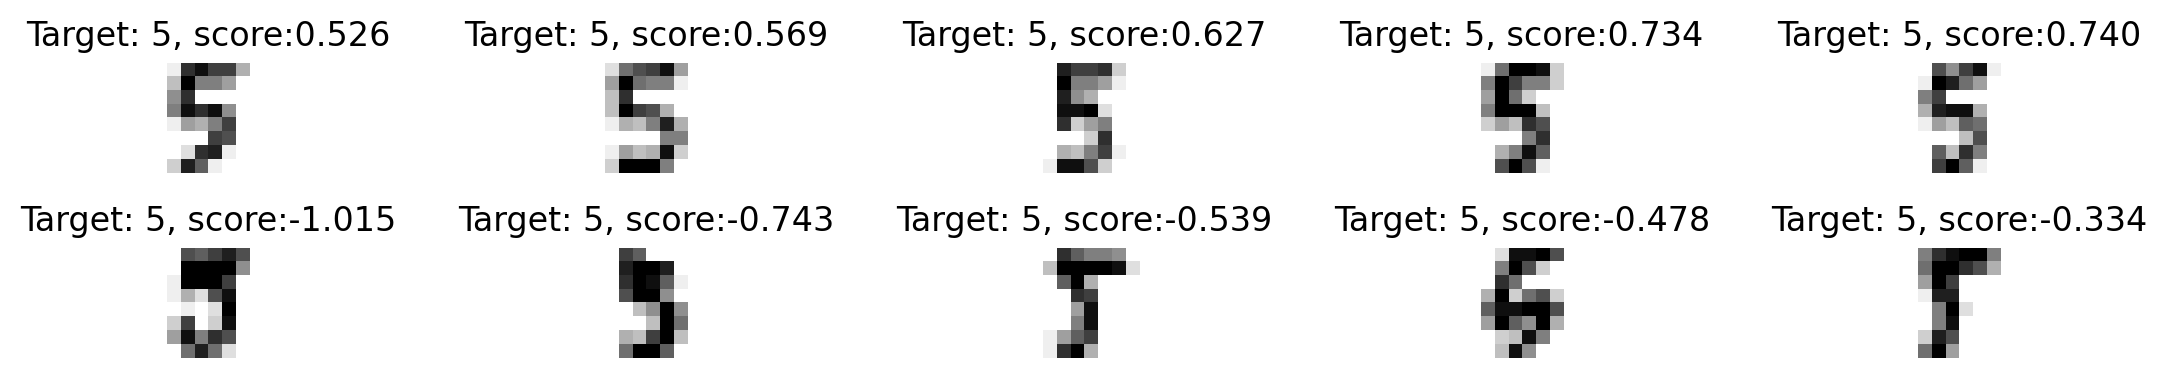

In [12]:
#############
#           #
# YOUR CODE #
#           #
#############

nu_value = 0.1
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_value).fit(X_train_5, y_train_5)

# Scoring and sorting test data
scores = svm.decision_function(X_test[y_test == 5])
sorted_indices = np.argsort(scores)

# Combining and reshaping observations
combined_observations_reshaped = np.vstack((X_test[y_test == 5][sorted_indices[-5:]], X_test[y_test == 5][sorted_indices[:5]])).reshape(10, 8, 8)

# Plotting top 5 highest and lowest observations
plot_ten_examples(combined_observations_reshaped, np.hstack((y_test[y_test == 5][sorted_indices[-5:]], y_test[y_test == 5][sorted_indices[:5]])), np.hstack((scores[sorted_indices[-5:]], scores[sorted_indices[:5]])))


Do the same plot with the observations in the test set whose true class is not 5

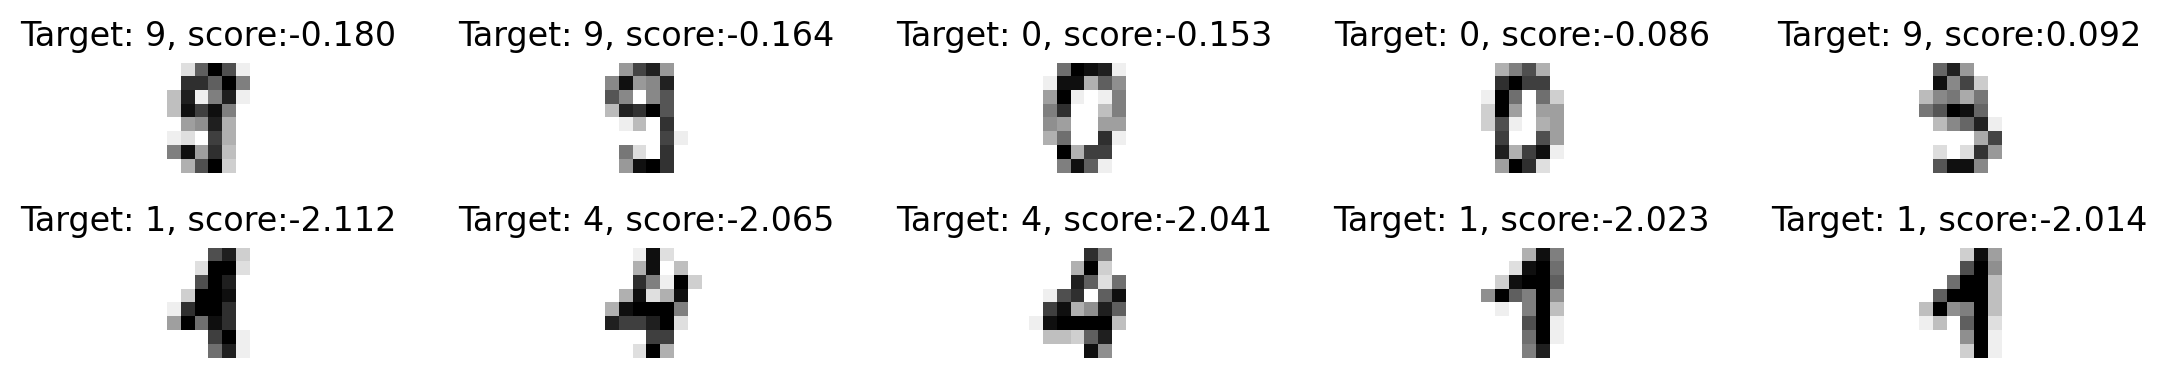

In [13]:
#############
#           #
# YOUR CODE #
#           #
#############

# Filter, score, and sort test data for non-class 5
scores_non_class_5 = svm.decision_function(X_test[y_test != 5])
sorted_indices_non_class_5 = np.argsort(scores_non_class_5)

# Combine and reshape observations
combined_observations_reshaped_non_class_5 = np.vstack((X_test[y_test != 5][sorted_indices_non_class_5[-5:]], X_test[y_test != 5][sorted_indices_non_class_5[:5]])).reshape(10, 8, 8)

# Plot top 5 highest and lowest observations for non-class 5
plot_ten_examples(combined_observations_reshaped_non_class_5, np.hstack((y_test[y_test != 5][sorted_indices_non_class_5[-5:]], y_test[y_test != 5][sorted_indices_non_class_5[:5]])), np.hstack((scores_non_class_5[sorted_indices_non_class_5[-5:]], scores_non_class_5[sorted_indices_non_class_5[:5]])))


**Comment on the aspect of these examples. Do the negative examples with the highest score look like 5s?**
- Negative with highest score is Targer 9, score: 0.092. No, it doesnt look like a 5.

**How are the scores of the negative examples that achieved the highest scores compared with the scores of the positive examples that achieved the lowest scores?**
- Highest score in the negative examples is 0.092. Lowest score in the positive examples is -1.015. The difference is significant.

## 2.2. Training set without 5, 6, 7, 8, and 9.

First use function `zero_four` to obtain the data corresponding to the task in which there are no instances of 5, 6, 7, 8 and 9 in the training set.


In [14]:
X_train_04, y_train_04, y_test_04 = zero_four(X_train, y_train, y_test,0.)

### 2.2.1 Dependence with `nu`

Repeat step 2.1.1 with this novelty detection task data.


[138. 136. 136. 136. 137. 145. 176. 221.] [321. 323. 323. 323. 322. 314. 283. 238.] [ 40.  39.  40.  40.  42.  49.  72. 116.] [400. 401. 400. 400. 398. 391. 368. 324.]


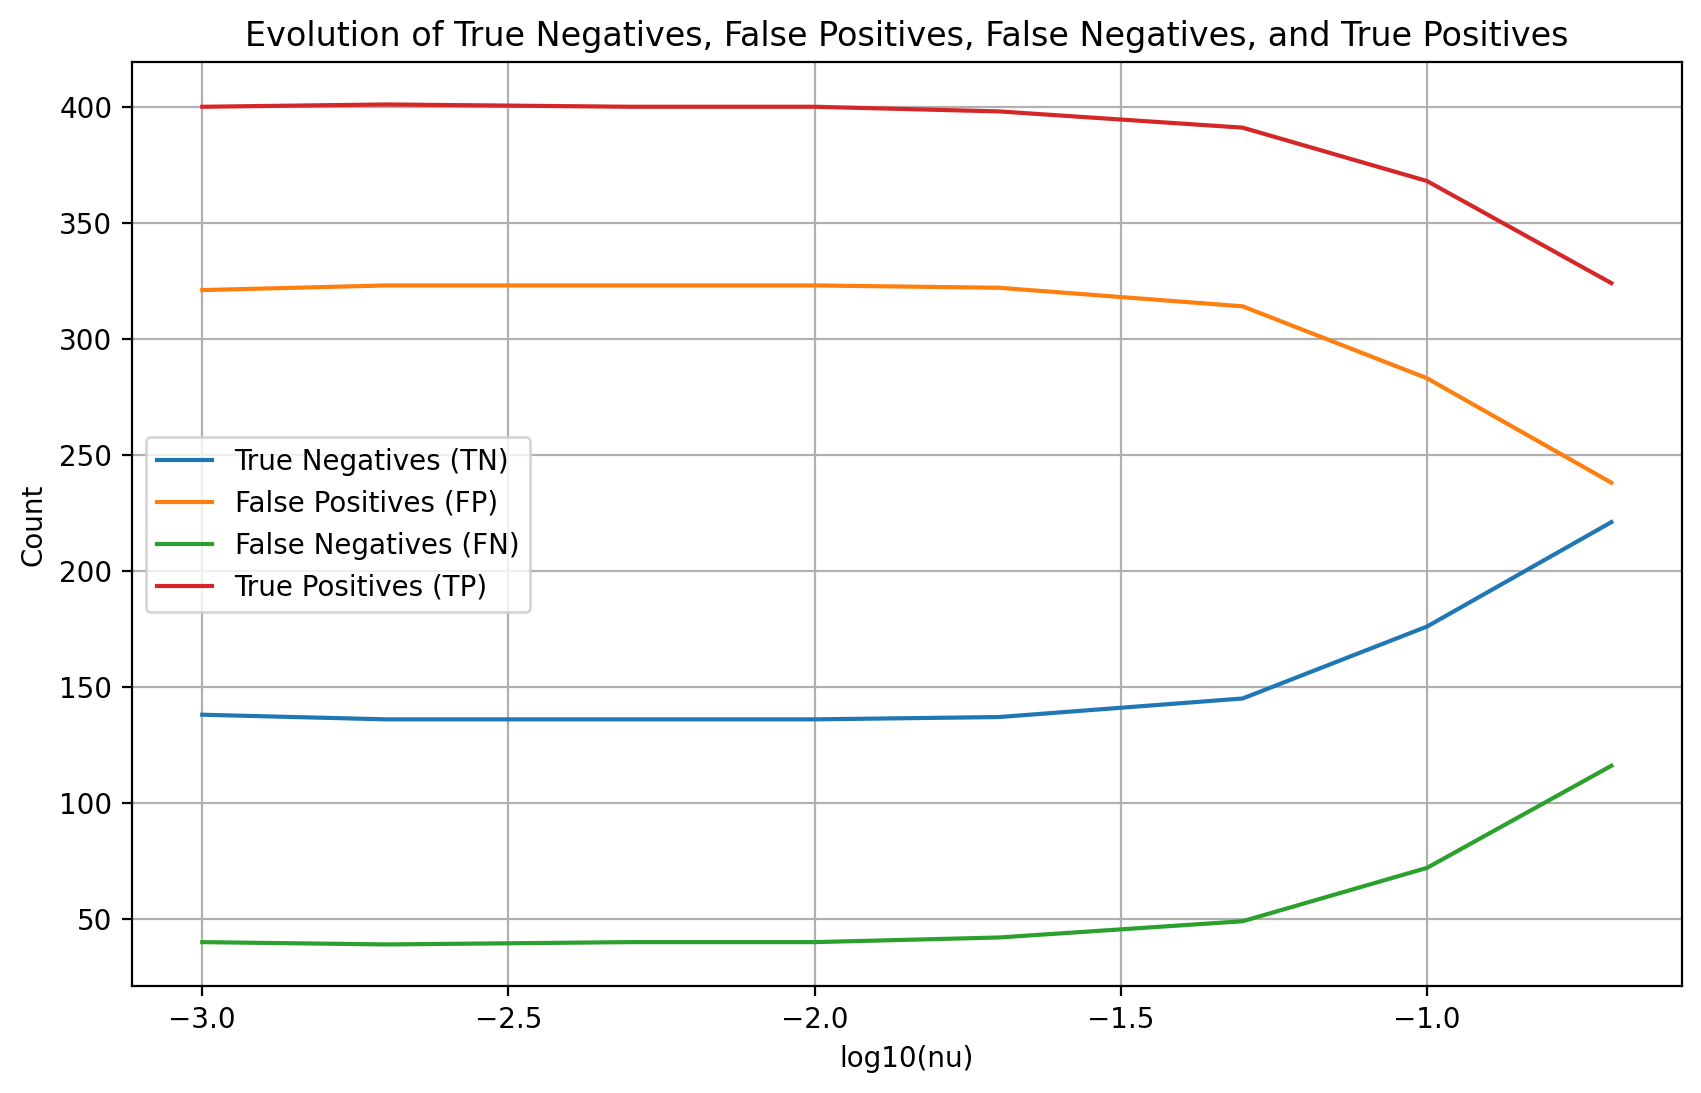

In [15]:
#############
# YOUR CODE #
#############

import numpy as np
import matplotlib.pyplot as plt

# Define the range of nu values
range_nu = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# Call simulate_oneclasssvm_nu with the outcome of just_fives
tn, fp, fn, tp = simulate_oneclasssvm_nu(X_train_04, X_test, y_train_04, y_test_04, range_nu)
print(tn,fp,fn,tp)

# Create a logarithmic scale for nu values
log_range_nu = np.log10(range_nu)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(log_range_nu, tn, label='True Negatives (TN)')
plt.plot(log_range_nu, fp, label='False Positives (FP)')
plt.plot(log_range_nu, fn, label='False Negatives (FN)')
plt.plot(log_range_nu, tp, label='True Positives (TP)')
plt.xlabel('log10(nu)')
plt.ylabel('Count')
plt.title('Evolution of True Negatives, False Positives, False Negatives, and True Positives')
plt.legend()
plt.grid(True)
plt.show()


**Discussion** Comment on the differences in performance with the other two tasks. 

This third task is closer to the task training with just 5s or to training without 5s?

1. **Performance Comparison with Just Fives Task (Task 1):**
   - **True Negatives (TN):** The count of true negatives is significantly higher in this task compared to the just fives task. This is expected because the model has learned to classify digits other than 5 (digits 0 to 4) as inliers and correctly predicts them as negatives in the test set.
   - **False Negatives (FN):** The count of false negatives is lower compared to the just fives task. This suggests that the model is better at detecting actual instances of 5s in the test set.

2. **Performance Comparison with Training Without 5s (Task 2):**
   - **True Negatives (TN):** The count of true negatives is much lower in this task compared to training without 5s. In this task, the model is more lenient in classifying digits 0 to 4 as inliers, resulting in fewer true negatives.
   - **False Negatives (FN):** The count of false negatives is higher in this task. This means that the model struggles to detect instances of actual 5s in the test set when they are present.
   - **True Positives (TP):** The count of true positives is significantly lower in this task. Similar to the previous task, the absence of 5s in the training data makes it challenging for the model to correctly identify instances of 5s in the test set.

**Task Similarity:** This task (training without 5, 6, 7, 8, and 9) is closer to the task of training without 5s in terms of performance. Both tasks face challenges in detecting unseen 5s in the training set, resulting in lower true positives. The absence of digits 5, 6, 7, 8, and 9 in the training set makes it difficult for the model to generalize to these unseen digits during testing, leading to lower true positive counts in both cases.

# 3. Introducing supervision
In this part you will explore the advantages of incorporating supervised learning in the form of a few instances of the negative class

Previously complete the code of the function `simulate_svm` that will help you with the experiments of this section. 

In [16]:
from sklearn.svm import SVC

def simulate_svm(x_train, x_test, y_train, y_test, fun, range_number_negatives):
  # fun: function that obtains the data for each novelty detection task.
  #      it can take the values no_fives, just_fives, zero_four. And yes, 
  #      in python functions can receive other functions as arguments
  # range_number_negatives: list with the number of samples in the negative 
  #                         class that you want in the training set to simulate
  #                         a novelty detection task with partial supervision

  tn = np.empty(len(range_number_negatives))
  fp = np.empty(len(range_number_negatives))
  fn = np.empty(len(range_number_negatives))
  tp = np.empty(len(range_number_negatives))
  """
  YOUR CODE
  1. create a SVM for classification with RBF kernel, C fixed to 1e4 and a 
     value of gamma set to 'scale'
  2. Loop for all the values in range_number_negatives
     2.1 call fun to obtain the data to simulate a partially supervised novelty
         detection task with the number of observations of the negative class in
         the training set corresponding to this iteration of the loop
     2.2 train the SVM with the outcome of step 2.1
     2.3 get the class predictions for the test set
     2.4 call confusion_matrix with y_test and the outcome of point 2.3 and 
         fill the positions in tn, fp, fn and tp corresponding to this iteration
         of the loop  
  """

  svm_classifier = SVC(kernel='rbf', C=1e4, gamma='scale')
    
  for i, num_negatives in enumerate(range_number_negatives):
        x_train_partial, y_train_partial, y_test_partial = fun(x_train, y_train, y_test, num_negatives)

        svm_classifier.fit(x_train_partial, y_train_partial)

        y_pred = svm_classifier.predict(x_test)

        cm = confusion_matrix(y_test_partial, y_pred)
        tn[i], fp[i], fn[i], tp[i] = cm.ravel()

  return tn, fp, fn, tp

## 3.1 Supervision in the only 5s task

Obtain a logarithmic range for the values of the number of instances of the negative class (non 5s) in the training set. Use 10 values between 1 and the maximum value equal to the number of non 5s in the training set.

Hint: numpy logspace could serve for this purpose. And remember the elements in the range should be integers...

In [21]:
#############
# YOUR CODE #
#############

# Calculate the number of non-5 instances in the training set
max_num_non_5 = np.sum(y_train != 5)

# Define the number of values between 1 and the maximum
num_values = 10

# Create a logarithmic range between 1 and the maximum
logarithmic_range_5 = np.logspace(0, np.log10(max_num_non_5), num=num_values, endpoint=True, base=10, dtype=int)

# Display the logarithmic range
print(logarithmic_range_5)

[  1   2   4   9  19  41  87 183 386 814]


Call `simulate_svm` to obtain the variation of TN, FP, FN and TP as the supervision of the problem increases.

Make a plot with the evolution of these 4 performance metrics. To compare with the unsupervised part, in this plot, show with **constant** dashed lines the values for  TN, FP, FN and TP obtained by OneClassSVM with the best value of `nu`.

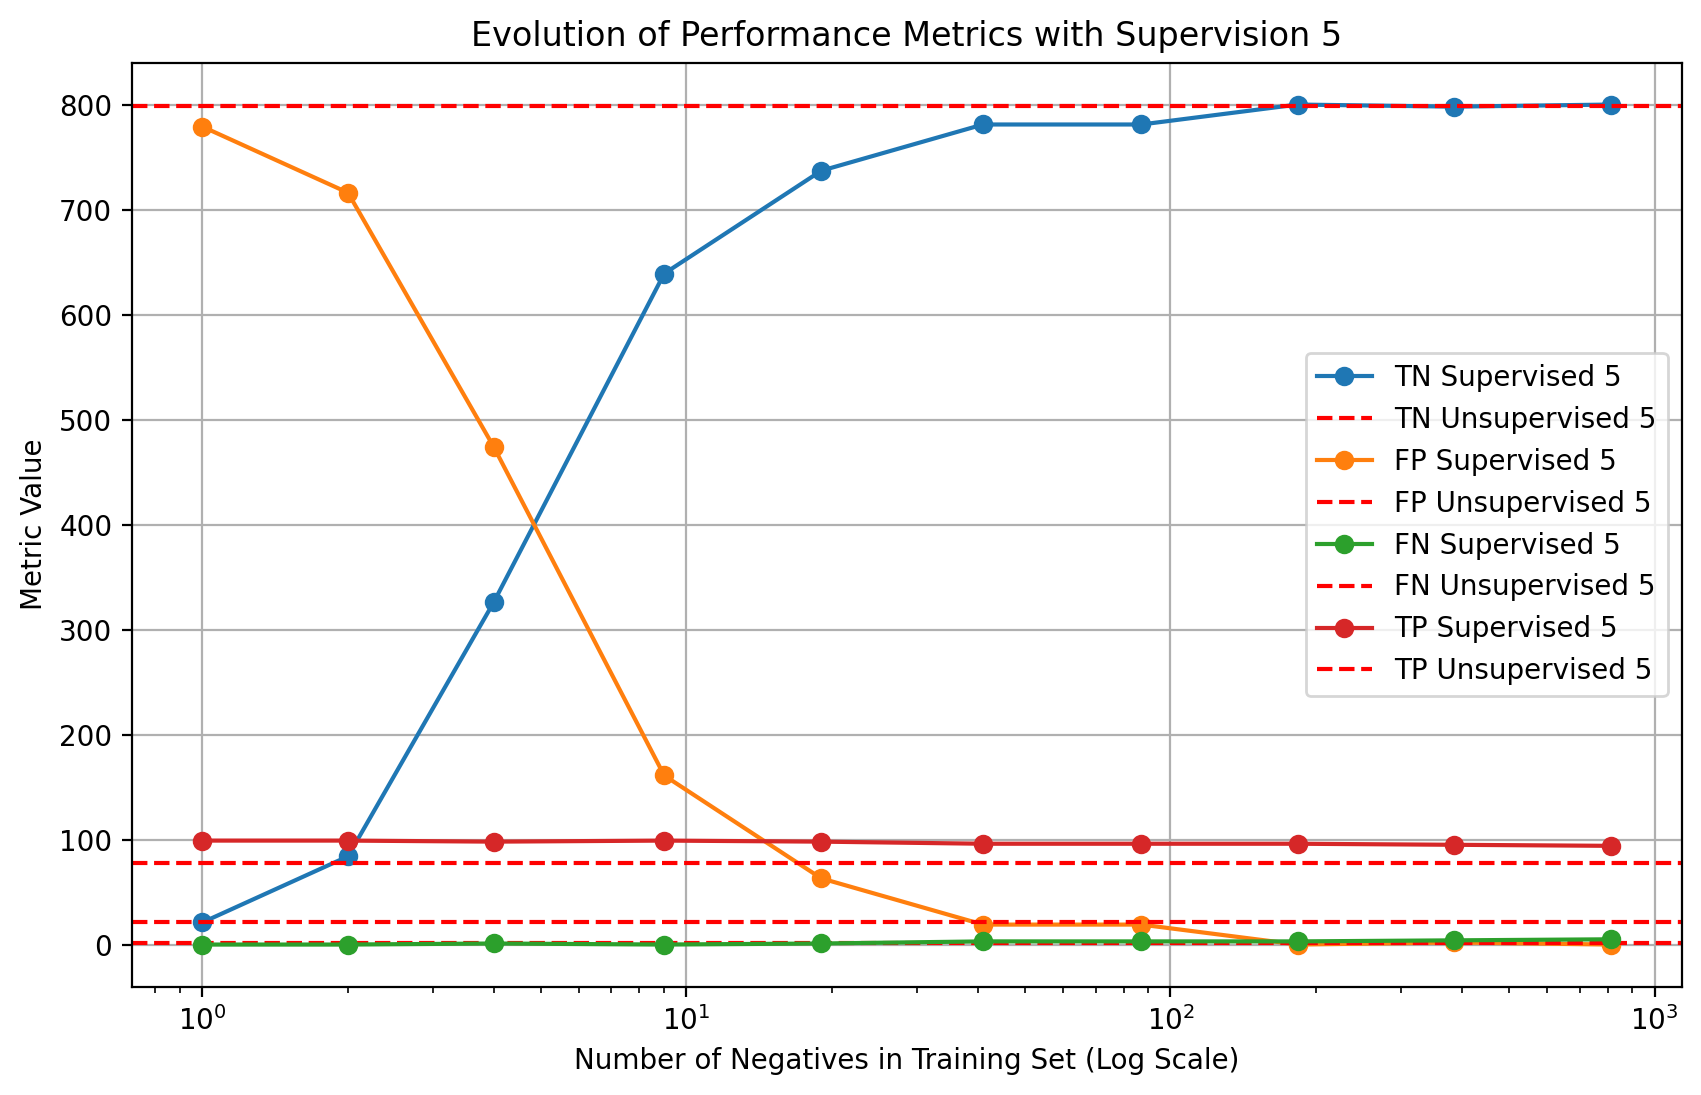

In [27]:
# Call simulate_svm with just_fives and logarithmic_range_5
tn_sup_5, fp_sup_5, fn_sup_5, tp_sup_5 = simulate_svm(X_train, X_test, y_train, y_test, fun=just_fives, range_number_negatives=logarithmic_range_5)

# Create and fit OneClassSVM for unsupervised case with class 5
nu_value = 0.1
svm_unsup_5 = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_value).fit(X_train_5, y_train_5)

# Get predictions for unsupervised case
svm_preds_unsup_5 = svm_unsup_5.predict(X_test)
tn_unsup_5, fp_unsup_5, fn_unsup_5, tp_unsup_5 = confusion_matrix(y_test_5, svm_preds_unsup_5).ravel()

# Plot the results
plt.figure(figsize=(10, 6))
for label, metric in zip(['TN', 'FP', 'FN', 'TP'], [tn_sup_5, fp_sup_5, fn_sup_5, tp_sup_5]):
    plt.plot(logarithmic_range_5, metric, marker='o', label=f'{label} Supervised 5')
    plt.axhline(y=eval(f'{label.lower()}_unsup_5'), color='red', linestyle='--', label=f'{label} Unsupervised 5')

plt.xscale('log')
plt.xlabel('Number of Negatives in Training Set (Log Scale)')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Evolution of Performance Metrics with Supervision 5')
plt.grid(True)
plt.show()


**Discussion**

Discuss the evolution of the 4 performance magnitudes as the number of negative samples in the training set increases.

- The supervised true negatives grew exponentially before slowly plateauing at 800 metric value, suggesting a saturation point where the model cannot improve TN further.
- The supervised false positive fell at a similar rate that the TN grew until slowly plateauing at 0 metric value. This implies that the model becomes highly accurate in avoiding false positive predictions as the number of negative samples increases.
- The supervised true positive only fell very slightly throughout but not reaching the TP unsupervised line. This indicates that the supervised model maintains its ability to correctly classify digit 5 instances as positive, even with the introduction of more negative samples.
- The supervised false negative increased very slightly as the number of negatives increased. However, this increase is not significant, indicating that the model's ability to correctly identify digit 5 instances as positive remains relatively stable.

Notice the OneClassSVM can be regarded as 0 negative samples. Is there any range of values of negative instances for which in any performance measure the OneClassSVM performs better than the SVM?

- When the number of negative samples in training set is lower, the performance measures better than the SVM.

## 3.2 Supervision in the without 5, 6, 7, 8, and 9 task


Repeat section 3.1 but now in the task in which the negative class are digits 5, 6, 7, 8 and 9 and the positive class is formed by digits 0, 1, 2, 3, 4.

Include in your discussion the comparison between the three tasks.

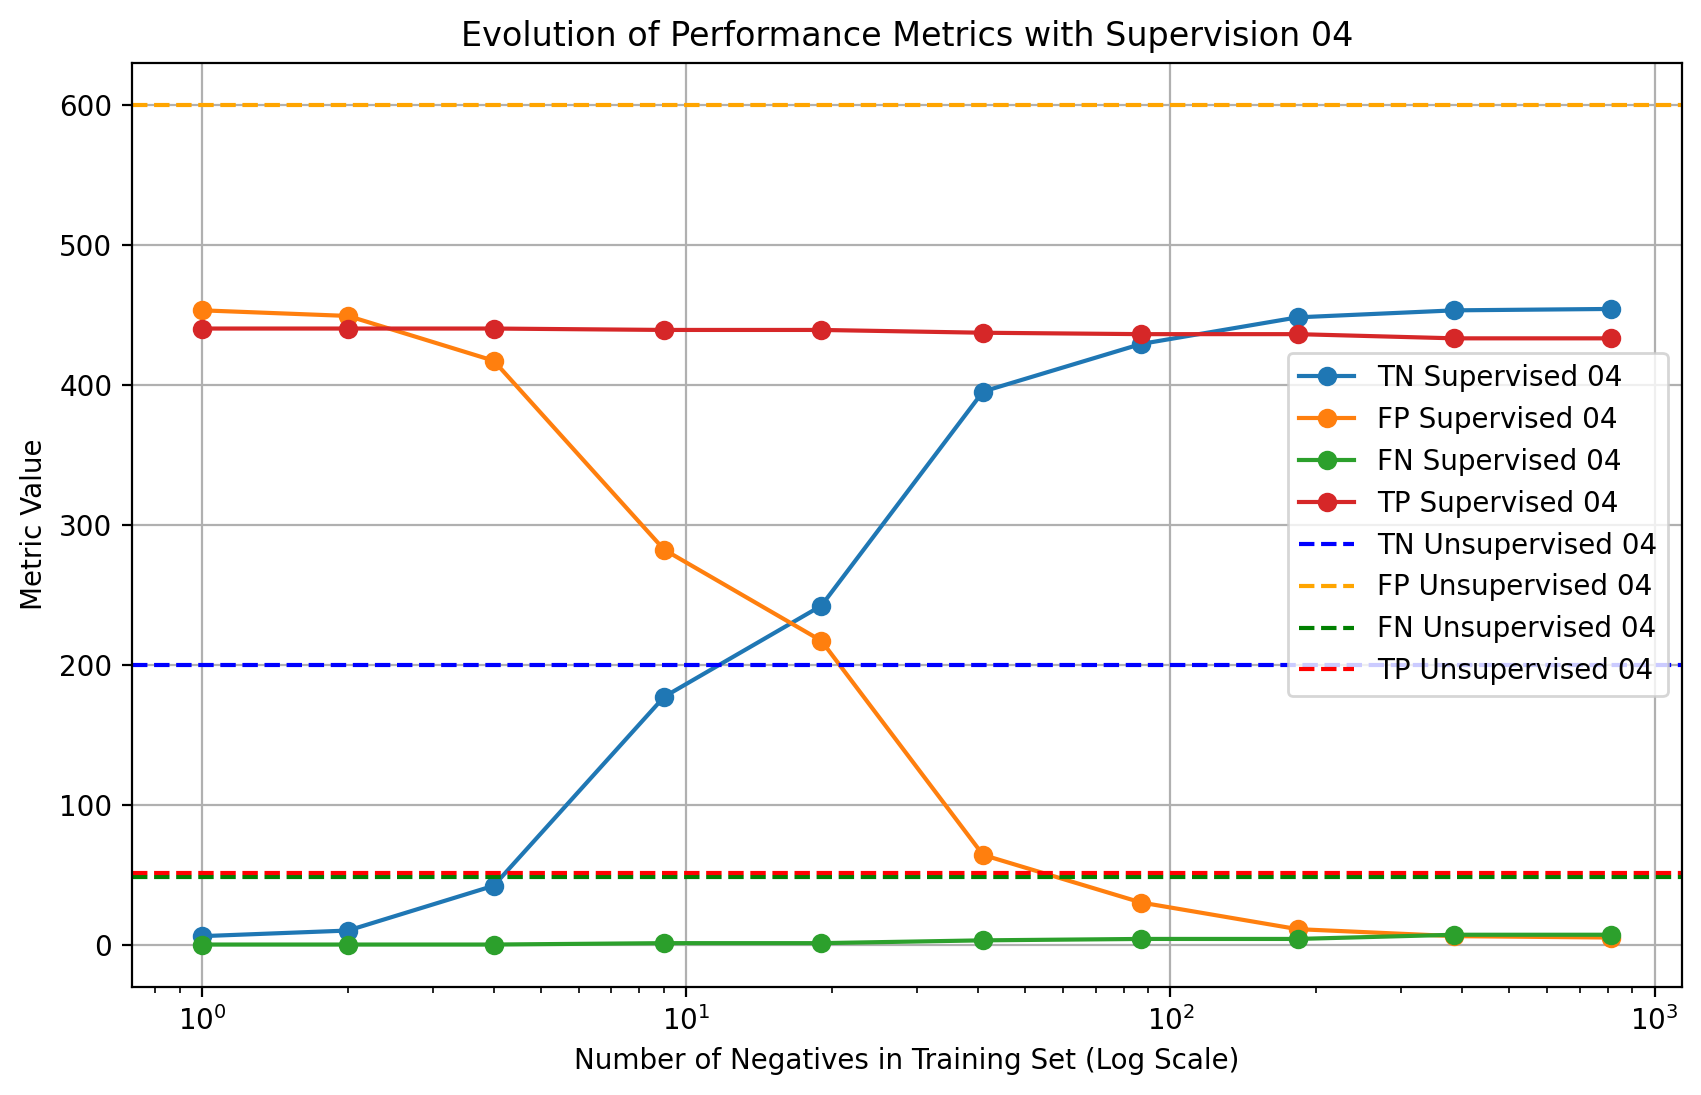

In [28]:
# Calculate the number of non-only-4 instances in the training set
max_num_non_04 = np.sum(y_train >= 5)

# Define the number of values between 1 and the maximum
num_values = 10

# Create a logarithmic range between 1 and the maximum
logarithmic_range_04 = np.logspace(0, np.log10(max_num_non_5), num=num_values, endpoint=True, base=10, dtype=int)

# Call simulate_svm with the function zero_four and range logarithmic_range_04 obtained earlier
tn_supervised_04, fp_supervised_04, fn_supervised_04, tp_supervised_04 = simulate_svm(X_train, X_test, y_train, y_test, fun=zero_four, range_number_negatives=logarithmic_range_04)

# Create and fit an OneClassSVM for the unsupervised case
nu_value = 0.1
svm_unsupervised_04 = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_value).fit(X_train_04, y_train_04)

# Get predictions for the unsupervised case
svm_predictions_unsupervised_04 = svm_unsupervised_04.predict(X_test)
svm_cm_unsupervised_04 = confusion_matrix(y_test_5, svm_predictions_unsupervised_04)
tn_unsupervised_04, fp_unsupervised_04, fn_unsupervised_04, tp_unsupervised_04 = svm_cm_unsupervised_04.ravel()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(logarithmic_range_04, tn_supervised_04, label='TN Supervised 04', marker='o')
plt.plot(logarithmic_range_04, fp_supervised_04, label='FP Supervised 04', marker='o')
plt.plot(logarithmic_range_04, fn_supervised_04, label='FN Supervised 04', marker='o')
plt.plot(logarithmic_range_04, tp_supervised_04, label='TP Supervised 04', marker='o')

# Plot constant dashed lines for unsupervised case
plt.axhline(y=tn_unsupervised_04, color='blue', linestyle='--', label='TN Unsupervised 04')
plt.axhline(y=fp_unsupervised_04, color='orange', linestyle='--', label='FP Unsupervised 04')
plt.axhline(y=fn_unsupervised_04, color='green', linestyle='--', label='FN Unsupervised 04')
plt.axhline(y=tp_unsupervised_04, color='red', linestyle='--', label='TP Unsupervised 04')

plt.xscale('log')
plt.xlabel('Number of Negatives in Training Set (Log Scale)')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Evolution of Performance Metrics with Supervision 04')
plt.grid(True)
plt.show()


# 4. Conclusions

- Which of the novelty detection taks is more difficult? A task is more difficult as it is harder to yield good performance.
The most difficult novelty detection task among the ones considered appears to be the task of training without 5s in the dataset. This task is more challenging because it involves detecting a specific digit (5) among the remaining digits (0 to 4) in the absence of any labeled instances of 5 during training.

- For each task, which is the amount of supervision (number of negative labelled observations in the training set) that makes SVM outperform OneClassSVM?
- With 5s:
    - about 10^2 in log scale
- Only 4s:
    - slightly past 10^2 and before 10^3 in log scale.